The goal of this notebook is to compile a list of chord n-grams by frequency from the entire database.
My main goal is to do this counting chords as harmonically equivalent, but I will also do it more literally.

In [68]:
# importing basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import copy
from collections import Counter, deque

# read in the data set
df = pd.read_csv('../../data/clean.csv', low_memory=False)

In [69]:
#there is a single datapoint which contains a chord 'sC' which is not in the chord dictionary; drop this row
print(df[df['spotify_song_id']=='0cUssfb9LDMpEXy812iWCO'])
df=df[df['spotify_song_id']!='0cUssfb9LDMpEXy812iWCO']

        Unnamed: 0                                             chords  \
138876      138876  <intro_1> C Emin F C G F Fsus2/E F C G F Fsus2...   

                                               chord_dict  num_sections  \
138876  {'intro_1': 'C Emin F C G F Fsus2/E F C G F Fs...             1   

        tot_chords  tot_unique_chords  unique_chord_density  \
138876          60                  7              0.116667   

        unique_2gram_density  unique_3gram_density  unique_4gram_density  \
138876                  0.25              0.366667                  0.45   

        unique_5gram_density  unique_2gram_difference release_date  decade  \
138876              0.516667                 0.133333   2011-03-08  2010.0   

       main_genre         spotify_song_id       spotify_artist_id  
138876        pop  0cUssfb9LDMpEXy812iWCO  68524z8sd176IRenNb1Fjy  


In [70]:
#focus just on chords, decades and genre
df=df[['chords','main_genre','decade']]
df.shape

(300713, 3)

In [71]:
# Read the mapping CSV file
chord_relations = pd.read_csv('../data/chords_mapping.csv')

# Create a dictionary with keys the "chords" and values the "degrees"
chord_degrees = dict(zip(chord_relations['Chords'], chord_relations['Degrees']))
for key, value in chord_degrees.items():
    chord_degrees[key] = ast.literal_eval(value)

# replacing spaces with commas
def replace_space_with_comma(my_string):
    return my_string.replace(" ",",")

# replacing spaces with commons in all chords in all rows of the data
df.loc[:,'chords'] = df['chords'].apply(replace_space_with_comma)

# Remove section markers
def remove_section_markers(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '<':
            # Skip until after the following ", "
            j = my_string.find('>', i)
            if j == -1:
                break  # no closing '>', stop
            i = j + 2  # skip '>,' and the space
        else:
            result.append(my_string[i])
            i += 1
    assert('<' not in result)
    assert('>' not in result)
    return ''.join(result)

df.loc[:,'chords'] = df['chords'].apply(remove_section_markers)

# Removing inversions
def remove_inversions(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '/':
            # Skip until after the following ", "
            j = my_string.find(',', i)
            if j == -1:
                break  # no closing comma, stop
            i = j  # skip comma
        else:
            result.append(my_string[i])
            i += 1
    return ''.join(result)

df.loc[:,'chords'] = df['chords'].apply(remove_inversions)


In [72]:
# Read the mapping CSV file
chord_relations = pd.read_csv('../data/chords_mapping.csv')

# Create a dictionary with keys the "chords" and values the "degrees"
chord_degrees = dict(zip(chord_relations['Chords'], chord_relations['Degrees']))
for key, value in chord_degrees.items():
    chord_degrees[key] = ast.literal_eval(value)
    
# full list of chords from the chords_mapping csv
known_chords = list(chord_degrees.keys())

In [73]:
# method to transpose a chord in vector format
def transpose_chord_up(chord_vector, num_semitones):
    d = deque(chord_vector)
    d.rotate(num_semitones)
    return(list(d))
    
# method to return true if chord_1 and chord_2 are just tranposed versions of each other
def is_harmonic_equivalent(chord_1, chord_2):
    # if they have different numbers of notes, then we don't have to check if 
    # any of the transpositions are equal
    if sum(chord_1) != sum(chord_2):
        return False

    # if they have the same number of notes, just rotate through the 12 possible transpositions to check
    for i in range(12):
        if np.array_equal(chord_1, transpose_chord_up(chord_2, i)):
            return True

    return False



In [74]:
# function to convert a string of comma-separated chords into a matrix, where each column denotes a chord
def string_to_chord_matrix(chord_sequence):
    # split sequence over commas, ignoring any "empty string" chords
    chord_list = [c for c in chord_sequence.split(',') if c != '']
    
    # then look up each chord in chord_degrees dictionary by the key value
    return np.array([chord_degrees[c][::-1] for c in chord_list]).transpose()

df.insert(loc = 1,
                  column = 'chord_matrix',
                  value = df['chords'].apply(string_to_chord_matrix),
                  allow_duplicates = False)

In [75]:
df.head()

,chords,chord_matrix,main_genre,decade
0,"E,D,A,E,D,A,E,D,A,E,D,A,E,D,A,E,D,A,C,E,G,D,A,...","[[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,...",metal,2000.0
1,"Csmin,A,Csmin,A,Csmin,A,Csmin,A,B,Csmin,A,Fsmi...","[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,...",metal,2000.0
2,"C,G,C,G,C,F,Dmin,G,Dmin,G,C,G,C,F,Dmin,G,Dmin,...","[[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,...",pop,2020.0
3,"G,Bmin,Amin,D,G,Bmin,Amin,D,G,Emin,Amin,D,G,Em...","[[1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,...",pop,2020.0
4,"Fsmin,Fsno3d,Bno3d,E,Fsno3d,Bno3d,E,Fsmin,B,As...","[[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,...",pop,2020.0


In the example with just chords, any chords that were not major or minor triads occurred too rarely for a ratio to be a useful feature. See if the most common 2-gram, C,G, occurs often/not often enough to be used as a ratio for a feature.

In [76]:
def transpose_matrix_up(chord_matrix, num_semitones):
    # transpose the entire matrix up by a number of semitones
    # this just means applying transpose_chord_up to each row
    return np.array([transpose_chord_up(row,num_semitones) for row in chord_matrix.T]).T

cg_2gram=np.array([[0,0,0,0,1,0,0,1,0,0,0,1],[1,0,0,0,1,0,0,0,0,1,0,0]]).T
transpositions=[]
for i in range(12):
    transpositions.append(transpose_matrix_up(cg_2gram,i))

transpositions

def cg_count(mat):
    # assumption: input song is a comma-separated string of chord names
    # assumption: input n_gram is a comma-separated string of chord names
    song_length = len(mat.T)
    count=0
    for i in range(song_length - 2):
        for j in range(12):
            if np.array_equal(mat[:,i:i+2],transpositions[j]):
                count+=1
    return count/song_length



In [77]:
df.insert(2,'cg_freq',df['chord_matrix'].apply(cg_count))

count    300713.000000
mean          0.148416
std           0.155447
min           0.000000
25%           0.000000
50%           0.103774
75%           0.250000
max           0.788235
Name: cg_freq, dtype: float64


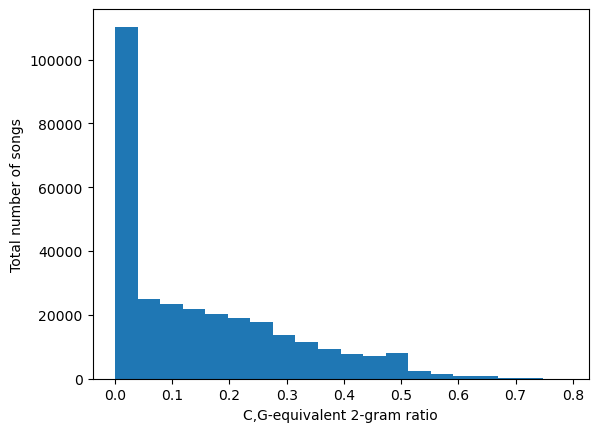

In [78]:
plt.hist(df.cg_freq,bins=20)
print(df.cg_freq.describe())
plt.xlabel('C,G-equivalent 2-gram ratio')
plt.ylabel('Total number of songs')
plt.show()

<Figure size 640x480 with 0 Axes>

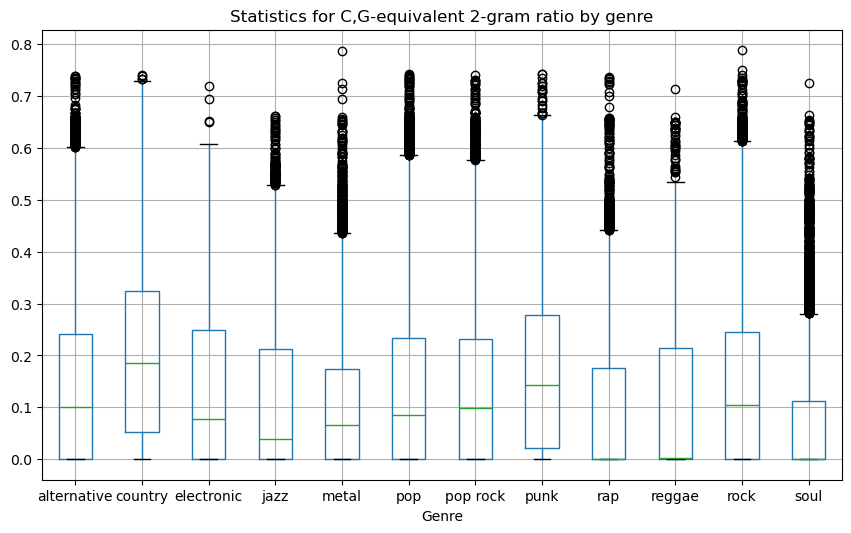

In [85]:
#box and whisker grouped by genre
plt.figure()
df.boxplot(column='cg_freq',by='main_genre',figsize=(10,6))
plt.xlabel('Genre')
plt.suptitle('')
plt.title('Statistics for C,G-equivalent 2-gram ratio by genre')
plt.show()

Text(0.5, 0, 'Average C,G-equivalent 2-gram ratio')

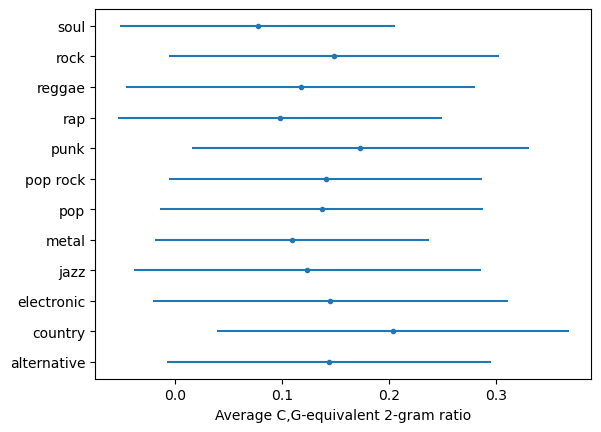

In [87]:
#plot of means and standard deviations by genre
cg_genre_means=df[['cg_freq','main_genre']].groupby('main_genre').mean()
cg_genre_std=df[['cg_freq','main_genre']].groupby('main_genre').std()
plt.errorbar(cg_genre_means.cg_freq,cg_genre_means.index,
             xerr=cg_genre_std.cg_freq, ls='None',marker='.')
plt.xlabel('Average C,G-equivalent 2-gram ratio')

punk and country seem to be the highest

<Figure size 640x480 with 0 Axes>

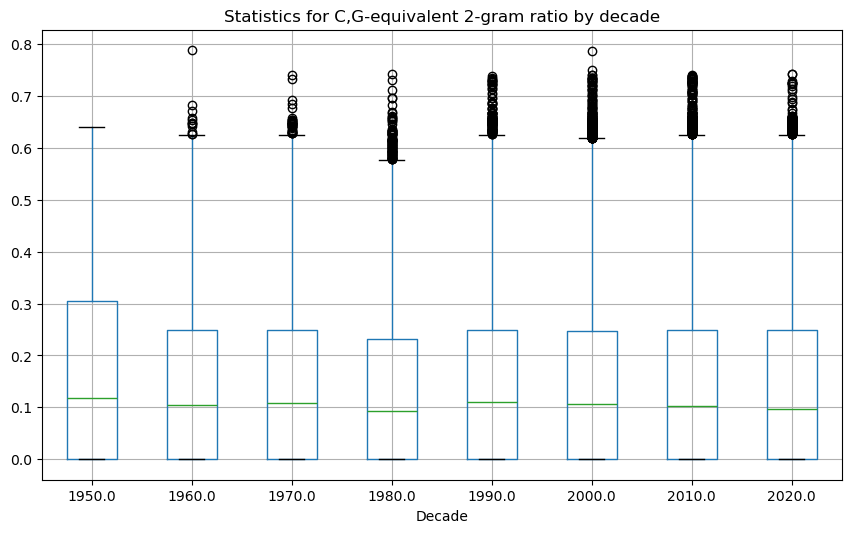

In [89]:
#box and whisker grouped by decade
plt.figure()
df.boxplot(column='cg_freq',by='decade',figsize=(10,6))
plt.xlabel('Decade')
plt.suptitle('')
plt.title('Statistics for C,G-equivalent 2-gram ratio by decade')
plt.show()

Text(0.5, 0, 'Average C,G-equivalent 2-gram ratio')

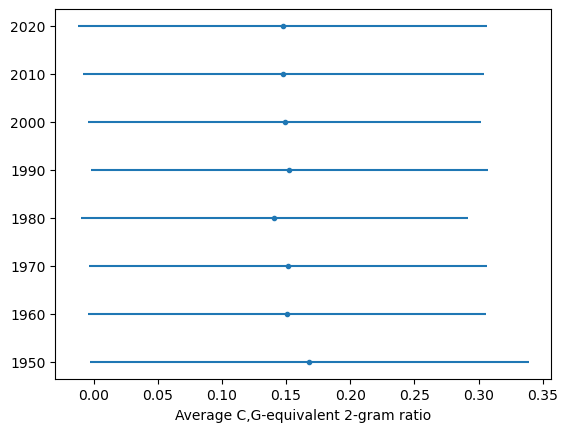

In [90]:
#plot of means and standard deviations by genre
cg_genre_means=df[['cg_freq','decade']].groupby('decade').mean()
cg_genre_std=df[['cg_freq','decade']].groupby('decade').std()
plt.errorbar(cg_genre_means.cg_freq,cg_genre_means.index,
             xerr=cg_genre_std.cg_freq, ls='None',marker='.')
plt.xlabel('Average C,G-equivalent 2-gram ratio')

Not useful for time analysis.

In [79]:




def is_harmonic_equivalent_matrix(chord_matrix_1, chord_matrix_2):
    # return true if chord_matrix_1 and chord_matrix_2 are just tranposed versions of each other

    # some basic checks to skip some looping when we can rule that out already
    if chord_matrix_1.shape != chord_matrix_2.shape:
        return False
    
    for i in range(len(chord_matrix_1)):
        if chord_matrix_1[i].sum() != chord_matrix_2[i].sum():
            return False

    # loop to check if they're the same
    for i in range(12):
        if np.array_equal(chord_matrix_1, transpose_matrix_up(chord_matrix_2, i)):
            return True

    return False



In [80]:
def n_grams(n):
    # return a counter object of n-grams, ignoring harmonic equivalence
    chord_n_gram_counter = Counter()
    for song in list_of_chord_lists:
        song_as_list = song.split(',')
        for i in range(len(song_as_list)-n+1):
            pair = ','.join(song_as_list[i:i+n])
            chord_n_gram_counter[pair] += 1
    return chord_n_gram_counter

In [81]:
def unique_n_grams(chord_n_gram_counter, output_messages=False, countdown=False):
    # return a counter object of harmonically unique n-grams
    # this will be a dictionary where keys are (harmonically unique) n-grams, and values are numbers of occurences in the database

    # make a deep copy of the input so we don't modify the original
    chord_n_gram_counter_copy = copy.deepcopy(chord_n_gram_counter)

    if output_messages:
        print("Initial length of numbers of n-grams with duplicates:",len(chord_n_gram_counter_copy))
        print()
    
    # we'll build up a counter of uniques
    unique_n_gram_counter = Counter()

    while len(chord_n_gram_counter_copy) > 0:
        n_gram_1 = chord_n_gram_counter_copy.most_common(1)[0][0]
        matrix_1 = string_to_chord_matrix(n_gram_1)
        
        # initialize a list of equivalent n-grams
        equivalent_n_grams = [n_gram_1]
        running_total = chord_n_gram_counter_copy[n_gram_1]

        # delete the current n-gram under consideration so that we don't count it as an equivalent to itself a second time
        del chord_n_gram_counter_copy[n_gram_1]
        
        # go through and find all harmonically equivalent chords to the most common chord left
        for n_gram_2 in chord_n_gram_counter_copy:
            matrix_2 = string_to_chord_matrix(n_gram_2)            
            if is_harmonic_equivalent_matrix(matrix_1, matrix_2):
                equivalent_n_grams.append(n_gram_2)
                running_total = running_total + chord_n_gram_counter_copy[n_gram_2]
    
        # set the value in the new counter to be the accumulated sum
        unique_n_gram_counter[n_gram_1] = running_total

        # go through chord_counts_copy and delete all the chords that were just added to the unique chord counter
        for e in equivalent_n_grams:
            del chord_n_gram_counter_copy[e]

        if output_messages:
            print("n-gram under consideration:",n_gram_1)
            print("Equivalent n-grams:",equivalent_n_grams)
            print("Number of equivalent n-grams:",len(equivalent_n_grams))
            print("New length of non-unique n-grams to check:",len(chord_n_gram_counter_copy))
            print("Updated list of unique n-grams:",unique_n_gram_counter)
            print()

        if countdown:
            print("Remaining n-grams:",len(chord_n_gram_counter_copy))

    return unique_n_gram_counter

In [82]:
# return true/false depending on if a song contains a literal/raw equivalent n_gram to the input n_gram
def contains_raw_n_gram(song, n_gram):
    # assumption: input song is a comma-separated string of chord names
    # assumption: input n_gram is a comma-separated string of chord names
    return (n_gram in song)

assert(contains_raw_n_gram('A,B,C,D,Emin','B,C,D'))

# return true/false depending on if a song contains a harmonically equivalent n_gram to the input n_gram
def contains_n_gram(song, n_gram):
    # assumption: input song is a comma-separated string of chord names
    # assumption: input n_gram is a comma-separated string of chord names
    song_as_matrix = string_to_chord_matrix(song)
    n_gram_as_matrix = string_to_chord_matrix(n_gram)
    song_length = len(song_as_matrix)
    n = len(n_gram_as_matrix)
    for i in range(song_length - n):
        if is_harmonic_equivalent_matrix(n_gram_as_matrix, song_as_matrix[i:i+n]):
            return True
    return False


In [83]:
# example of how to add a one-hot encoding column for whether songs contain a given n-gram, up to harmonic equivalent
song_df = copy.deepcopy(sample_data)
raw_chord = 'G,C' # representative concrete example of an n-gram
harmonic_function = '51' # new column title
song_df.insert(loc=len(song_df.columns),
               column = harmonic_function,
               value = song_df['chords'].apply(lambda song : int(contains_n_gram(song, raw_chord))))
song_df

NameError: name 'sample_data' is not defined